In [1]:
# # ML Trader
import numpy as np
import pandas as pd

import collections

from tqdm import tqdm

from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import datetime as dt

import winsound

import warnings
warnings.filterwarnings('ignore')

In [2]:
def before_sema(data):   
    data['sema_list'].append(data['tick'])    
    return(data)

def after_sema(data):     
    data['sema_list'].popleft()
    data['sema_list'].append(data['tick'])
    data['sema'] = list(pd.DataFrame(list(data['sema_list'])).ewm(span=data['sema_len']).mean()[0])[-1]
    return(data)

def before_lema(data):   
    data['lema_list'].append(data['tick'])    
    return(data)

def after_lema(data):     
    data['lema_list'].popleft()
    data['lema_list'].append(data['tick'])
    data['lema'] = list(pd.DataFrame(list(data['lema_list'])).ewm(span=data['lema_len']).mean()[0])[-1]
    return(data)

In [3]:
def print_report(data):
    display.clear_output(wait = True)
    print('--------------------------')
    print(f'Total PL : {sum(data["pl_list"])}')
    print('-----------')
    print(data['pl_list'])
    print('--------------------------')
    return()

In [4]:
def read_data(data):
    source_file_path = f'..\\data\\yearly_tick_data\\{data["year"]}.csv'

    if data['input_rows'] is None:
        data["df"] = pd.read_csv(source_file_path)
    else:
        data["df"] = pd.read_csv(source_file_path, nrows=data['input_rows'])
        
    data["df"] = data["df"][data["df"]['DateTime'].str.contains('|'.join(data['date_list']))]
#     data["df"] = data["df"][data["df"]['DateTime'].str.contains(data['date_val'])]
    
    data["df"]['tick'] = np.float()
    data["df"]['sema'] = np.float()
    data["df"]['lema'] = np.float()
    
    return(data["df"])

def get_dir(data):
    if not data['open_order']:
        if data['sema'] > data['lema']:
            data['position'] = 1

        elif data['sema'] < data['lema']:
            data['position'] = -1
    
    if data['open_order']:        
        if data['tick'] > data['lema']:
            data['position'] = 1

        elif data['tick'] < data['lema']:
            data['position'] = -1
    
    return(data)

In [5]:
def get_dir(data):
    
    if data['sema'] > data['lema']:
        data['position'] = 1

    elif data['sema'] < data['lema']:
        data['position'] = -1
    
    return(data)

In [6]:
def after_dir(data):   
    
    data['dir_list'].popleft()
    data['dir_list'].append(data['position'])   
    
    if sum(data['dir_list']) != 0:
        data['dir_change'] = False

    elif sum(data['dir_list']) == 0:
        data['dir_change'] = True
        #print(data['dir_list'])

    return(data)

In [7]:
def make_order(data):
    if not data['open_order']:
        if data['dir_change']:
            if data['position'] > 0:
                data['order_ask_price'] = data['ask']
                data['open_order'] = True
                data['open_order_type'] = 'long'
                
            elif data['position'] < 0:
                data['order_bid_price'] = data['bid']
                data['open_order'] = True
                data['open_order_type'] = 'short'
    return(data)

In [8]:
def close_order(data):
    if data['open_order']:
        if data['dir_change']:
            if data['position'] < 0:
                data['close_bid_price'] = data['bid']
                data['pl'] = np.round(data['close_bid_price'] - data['order_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                              
                
            elif data['position'] > 0:
                data['close_ask_price'] = data['ask']
                data['pl'] = np.round(data['order_bid_price'] - data['close_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
    return(data)

In [9]:
def tick_close(data):
    if data['open_order']:
        if data['open_order_type'] == 'short':
            if data['tick'] - data['lema'] >= 0:
                data['close_ask_price'] = data['ask']
                data['pl'] = np.round(data['order_bid_price'] - data['close_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
        if data['open_order_type'] == 'long':
            if data['lema'] - data['tick'] >= 0:
                data['close_bid_price'] = data['bid']
                data['pl'] = np.round(data['close_bid_price'] - data['order_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
    return(data)

In [10]:
def get_date_list(data):
    
    data['start_date'] = dt.datetime(year=data['start_date']['year'],
                      month=data['start_date']['month'],
                      day=data['start_date']['date'])

    data['end_date'] = dt.datetime(year=data['end_date']['year'],
                      month=data['end_date']['month'],
                      day=data['end_date']['date'])

    
    date_list = list(pd.date_range(data['start_date'],data['end_date'],freq='d').values)
    data['date_list'] = [str(x).split('T')[0].replace('-','') for x in date_list]
    return(data)

In [11]:
def get_run_duration(data):
    run_time = len(data["date_list"]) * 6
    hours = run_time//60
    mins = run_time%60
    print(f'Approx run time : {hours}-hours : {mins}-mins')

In [12]:
def split_date_col(data):
    data['total_df']['year_val'] = [x.year for x in data['total_df']['date']]
    data['total_df']['month_val'] = [x.month for x in data['total_df']['date']]
    data['total_df']['date_val'] = [x.day for x in data['total_df']['date']]
    data['total_df']['hour_val'] = [x.hour for x in data['total_df']['date']]
    data['total_df']['minute_val'] = [x.minute for x in data['total_df']['date']]

In [13]:
def plot_graph(data):
    
    figure(num=None, figsize=(50, 10), dpi=80, facecolor='w', edgecolor='k')

    data["df"]['tick'].plot(label = 'tick')
    data["df"]['sema'].plot(label = 'sema')
    data["df"]['lema'].plot(label = 'lema')
    plt.legend(loc="upper left")

In [14]:
def print_report(data):
    pl_list = list(data['pl_list'])
    net_pl = round(np.sum(pl_list),5)

    positive_pls = [i for i in pl_list if i > 0]
    negative_pls = [i for i in pl_list if i < 0]

    num_positive = len(positive_pls)
    num_negative = len(negative_pls)

    sum_positive = round(np.sum(positive_pls),5)
    sum_negative = round(np.sum(negative_pls),5)
    sum_total    = round(sum_positive + abs(sum_negative),5) 

    avg_positive = round(np.mean(positive_pls),5)
    avg_negative = round(np.mean(negative_pls),5)

    
    print('==============================')
    print(f'date_val          : {data["date_list"]}')    
    print(f'Total PL : {sum(data["pl_list"])}')
    print('-------------')
    print(f'net_pl            : {net_pl}/{sum_total}')  
    print('-------------')
    print(f'+ve               : num= {num_positive}    sum= +{sum_positive}    avg= +{avg_positive}')
    print(f'-ve               : num= {num_negative}    sum= {sum_negative}    avg= {avg_negative}')
    print('==============================')

In [15]:
def run_engine(data):
    num_recs = len(data["df"])
    for i in range(0, len(data["df"])):
        data['ask'] = data["df"]['Ask'][i]
        data['bid'] = data["df"]['Bid'][i]
        data['tick'] = (data['ask'] + data['bid'])/2    
        data["df"]['tick'][i] = data['tick']
        #data['dt_val'] = data["df"]['DateTime'][i]        
        data['dt_val'] = dt.datetime.strptime(data["df"]['DateTime'][i].split(".")[0],"%Y%m%d %H:%M:%S")

        # sema before after loops --------------------------------
        if len(data['sema_list']) < data['sema_len']:
            data =  before_sema(data)
            continue

        if len(data['sema_list']) == data['sema_len']:
            data = after_sema(data)     
        # ----------------------------------------------------------


        # lema before after loops --------------------------------
        if len(data['lema_list']) < data['lema_len']:
            data = before_lema(data)        
            continue

        if len(data['lema_list']) == data['lema_len']:
            data = after_lema(data)        
        # ----------------------------------------------------------


        data["df"]['sema'][i] = data['sema']
        data["df"]['lema'][i] = data['lema']

        data = get_dir(data)

        # lema before after loops --------------------------------
        if len(data['dir_list']) < 2:
            data['dir_list'].append(data['position'])   
            continue
        elif len(data['dir_list']) == 2:
            data = after_dir(data)
        # ----------------------------------------------------------

        data = tick_close(data)
        data = close_order(data)
        data = make_order(data)    
        
        display.clear_output(wait = True)
        print(np.round((i/num_recs) * 100,2))
        
        
    data["df"] = data["df"][data["df"]['sema'] != 0]
    data["df"] = data["df"][data["df"]['lema'] != 0]
    data["df"] = data["df"].reset_index(drop = True)
    
    return(data)

In [16]:
def run_engine(data):
    for i in tqdm(range(0, len(data["df"]))):
        data['ask'] = data["df"]['Ask'][i]
        data['bid'] = data["df"]['Bid'][i]
        data['tick'] = (data['ask'] + data['bid'])/2    
        data["df"]['tick'][i] = data['tick']
        #data['dt_val'] = data["df"]['DateTime'][i]        
        data['dt_val'] = dt.datetime.strptime(data["df"]['DateTime'][i].split(".")[0],"%Y%m%d %H:%M:%S")

        # sema before after loops --------------------------------
        if len(data['sema_list']) < data['sema_len']:
            data =  before_sema(data)
            continue

        if len(data['sema_list']) == data['sema_len']:
            data = after_sema(data)     
        # ----------------------------------------------------------


        # lema before after loops --------------------------------
        if len(data['lema_list']) < data['lema_len']:
            data = before_lema(data)        
            continue

        if len(data['lema_list']) == data['lema_len']:
            data = after_lema(data)        
        # ----------------------------------------------------------


        data["df"]['sema'][i] = data['sema']
        data["df"]['lema'][i] = data['lema']

        data = get_dir(data)

        # lema before after loops --------------------------------
        if len(data['dir_list']) < 2:
            data['dir_list'].append(data['position'])   
            continue
        elif len(data['dir_list']) == 2:
            data = after_dir(data)
        # ----------------------------------------------------------

        data = tick_close(data)
        data = close_order(data)
        data = make_order(data)    

    data["df"] = data["df"][data["df"]['sema'] != 0]
    data["df"] = data["df"][data["df"]['lema'] != 0]
    data["df"] = data["df"].reset_index(drop = True)
    
    return(data)

In [17]:
data = {}
data["year"] = 2021
data['total_df'] = pd.DataFrame()
data['sema_list'] = collections.deque()
data['lema_list'] = collections.deque()
data['dir_list'] = collections.deque()
data['pl_list'] =  collections.deque()
data['dt_list'] =  collections.deque()

data['open_order_type'] = None

In [18]:
data['input_rows'] = None

data['start_date'] = {'year':2021, 'month':3, 'date':8}
data['end_date']   = {'year':2021, 'month':3, 'date':12}

data['sema_len'] = 1000
data['lema_len'] = 2000

  0%|                                       | 21/451105 [00:00<38:06, 197.26it/s]

Record num : 451105


100%|███████████████████████████████████| 451105/451105 [28:02<00:00, 268.17it/s]


date_val          : ['20210308', '20210309', '20210310', '20210311', '20210312']
Total PL : -0.0048000000000000004
-------------
net_pl            : -0.0048/0.0642
-------------
+ve               : num= 53    sum= +0.0297    avg= +0.00056
-ve               : num= 186    sum= -0.0345    avg= -0.00019
Wall time: 28min 6s


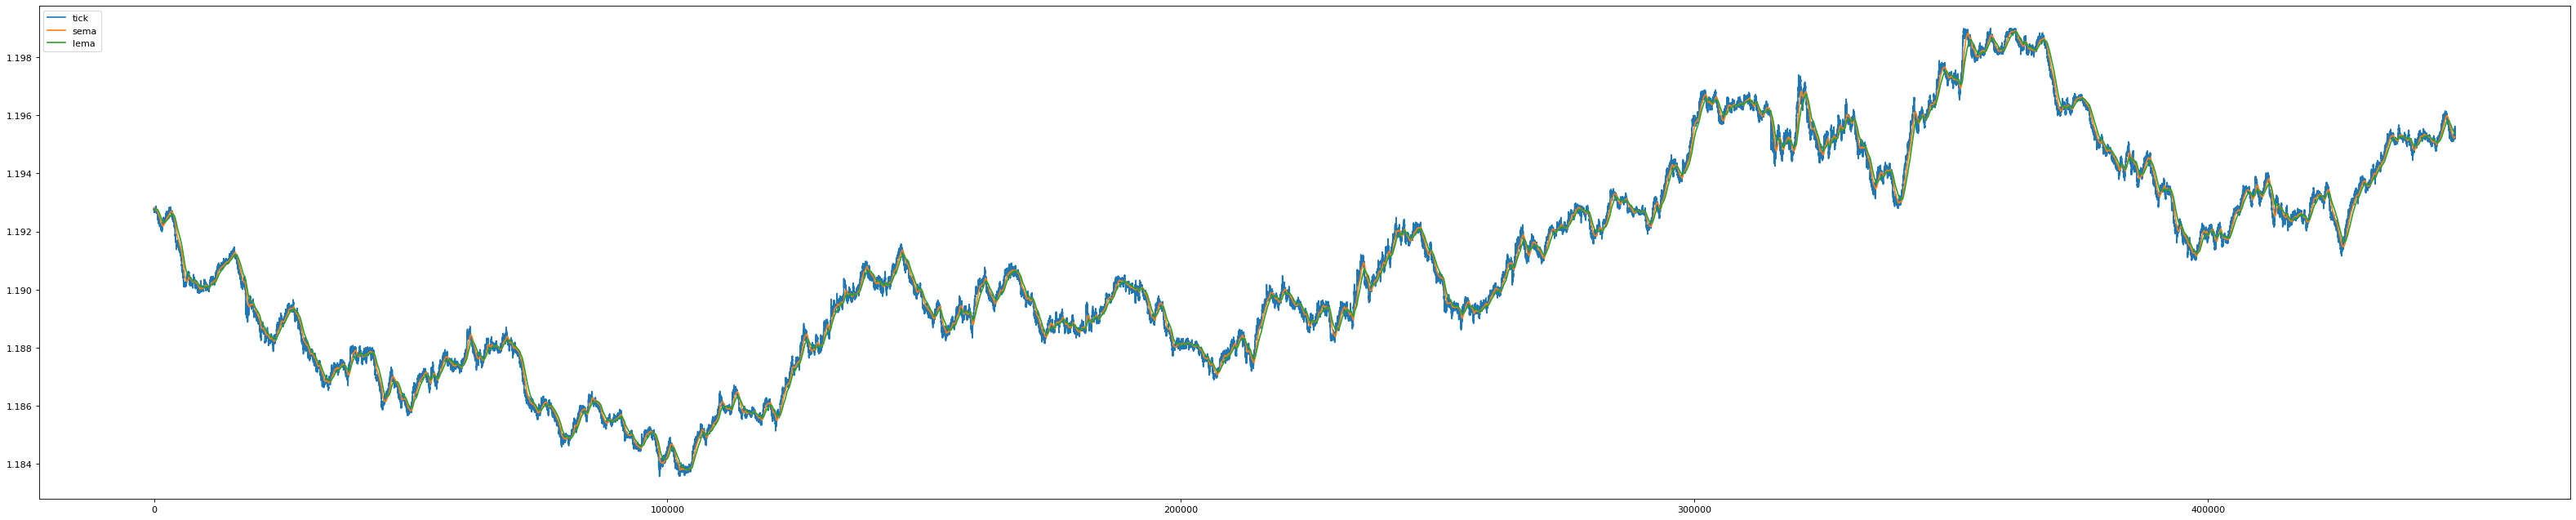

In [19]:
%%time
data = get_date_list(data)
read_data(data)
#data["df"] = data["df"][0:100]
print(f'Record num : {len(data["df"])}')    
data["df"] = data["df"].reset_index(drop = True)

data['open_order'] = False    
data = run_engine(data)

plot_graph(data)
print_report(data)
data['total_df'] = pd.DataFrame({'date':data['dt_list'], 'pls': data['pl_list']})
split_date_col(data)
data['total_df'] = data['total_df'][['date', 'year_val', 'month_val', 'date_val', 'hour_val','minute_val', 'pls']]
data["total_df"] = data["total_df"].reset_index(drop = True)    
data['file_name'] = f'data\{data["start_date"].year}-{data["start_date"].month}-({data["start_date"].day}-{data["end_date"].day}).csv'

data['total_df'].to_csv(data['file_name'], index = False) 

In [20]:
print(data['total_df'].groupby(['date_val'])['pls'].sum())

date_val
8     0.0009
9    -0.0047
10   -0.0020
11    0.0003
12    0.0007
Name: pls, dtype: float64


In [21]:
data['total_df']['pls'].value_counts()

-0.0001    81
-0.0002    61
-0.0003    35
-0.0000    24
 0.0001    12
 0.0003     8
-0.0004     8
 0.0007     6
 0.0002     5
 0.0004     4
 0.0008     4
 0.0006     4
 0.0011     2
 0.0009     1
 0.0014     1
 0.0012     1
 0.0020     1
 0.0005     1
-0.0005     1
 0.0024     1
 0.0018     1
 0.0013     1
Name: pls, dtype: int64

In [22]:
data['total_df']

,date,year_val,month_val,date_val,hour_val,minute_val,pls
0,2021-03-08 01:09:18,2021,3,8,1,9,-0.0001
1,2021-03-08 02:12:32,2021,3,8,2,12,-0.0000
2,2021-03-08 02:56:20,2021,3,8,2,56,0.0018
3,2021-03-08 04:02:27,2021,3,8,4,2,-0.0002
4,2021-03-08 04:20:41,2021,3,8,4,20,-0.0002
...,...,...,...,...,...,...,...
258,2021-03-12 17:55:15,2021,3,12,17,55,-0.0001
259,2021-03-12 18:47:17,2021,3,12,18,47,0.0001
260,2021-03-12 19:22:33,2021,3,12,19,22,-0.0001
261,2021-03-12 21:04:29,2021,3,12,21,4,0.0006


In [23]:
winsound.PlaySound('C:\\Windows\\Media\\chimes.wav', winsound.SND_ASYNC)